In [1]:
import pandas as pd
import glob
import os

In [5]:
!pip install openpyxl

## Merge multiple years of dataset

In [8]:
def standardize_datetime(dt):
    """
    Standardize datetime objects by removing timezone information.
    
    Parameters:
    dt: datetime object or pandas timestamp
    
    Returns:
    standardized datetime object
    """
    if pd.isna(dt):
        return dt
    if hasattr(dt, 'tz'):
        # Convert to timezone-naive datetime
        return dt.tz_localize(None)
    return dt

In [11]:
def merge_crime_data(data_path, file_pattern='*.xlsx'):
    """
    Merge multiple yearly Excel crime data files into a single DataFrame.
    
    Parameters:
    data_path (str): Path to the directory containing Excel files
    file_pattern (str): Pattern to match Excel files
    
    Returns:
    pandas.DataFrame: Merged dataset
    dict: Summary statistics about the merge
    """
    all_dataframes = []
    
    # Get list of all Excel files
    files = glob.glob(os.path.join(data_path, file_pattern))
    
    for file in sorted(files):
        year = os.path.basename(file).split('.')[0]  # Get filename without extension
        try:
            # Read Excel file
            df = pd.read_excel(file)
            
            # Basic data cleaning
            # Convert date column
            df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'], errors='coerce')

            # Remove timezone information
            df['OCCURRED_ON_DATE'] = df['OCCURRED_ON_DATE'].apply(standardize_datetime)
            
            # Convert coordinates to numeric, handling any errors
            df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
            df['Long'] = pd.to_numeric(df['Long'], errors='coerce')

            # Ensure YEAR is numeric
            df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
            
            all_dataframes.append(df)
            
        except Exception as e:
            print(f"Error processing {year}: {str(e)}")
    
    if all_dataframes:
        merged_df = pd.concat(all_dataframes, ignore_index=True)
        
        # Remove duplicate incidents based on INCIDENT_NUMBER
        merged_df.drop_duplicates(subset=['INCIDENT_NUMBER'], keep='first', inplace=True)
        
        # Sort by date
        merged_df.sort_values('OCCURRED_ON_DATE', inplace=True)

        # Verify date column is timezone-naive
        print("Verifying datetime consistency...")
        merged_df['OCCURRED_ON_DATE'] = merged_df['OCCURRED_ON_DATE'].apply(standardize_datetime)
    
        return merged_df
    else:
        raise ValueError("No datasets were successfully loaded")

In [12]:
# Example directory path - replace with your actual path
data_path = "./dataset"

# Merge datasets
print("Merging datasets...")
merged_df = merge_crime_data(data_path)
        
# Save merged dataset
output_file = 'merged_crime_data_2015_2024.xlsx'
merged_df.to_excel(output_file, index=False)
print(f"\nMerged data saved to {output_file}")

Merging datasets...
Verifying datetime consistency...

Merged data saved to merged_crime_data_2015_2024.xlsx


once merged, lets try to load in the dataset to preview it.

In [14]:
df = pd.read_excel("merged_crime_data_2015_2024.xlsx")
df.head(5)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I172040657,2629,Harassment,HARASSMENT,C11,397,NaN,2015-06-15,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)"
1,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,,NaN,2015-06-15,2015,6,Monday,0,Part Three,BERNARD,NaN,NaN,NaN
2,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,NaN,2015-06-15,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)"
3,I152051083,3115,Investigate Person,INVESTIGATE PERSON,A7,20,NaN,2015-06-15,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247,"(42.37702319, -71.03224730)"
4,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,NaN,2015-06-15,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)"


## Exploration data analysis begins

In [15]:
# filtering
new_df = df[['OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'YEAR', 'Lat', 'Long']]
new_df.shape

(755610, 6)

In [16]:
# Check for missing values
new_df.isnull().sum()

OFFENSE_DESCRIPTION        0
DISTRICT                4432
REPORTING_AREA         30254
YEAR                       0
Lat                    41021
Long                   41021
dtype: int64

In [19]:
new_df = new_df.dropna()

## Basic Visualizations

<Axes: title={'center': 'Number of Offenses Per Year'}, xlabel='YEAR'>

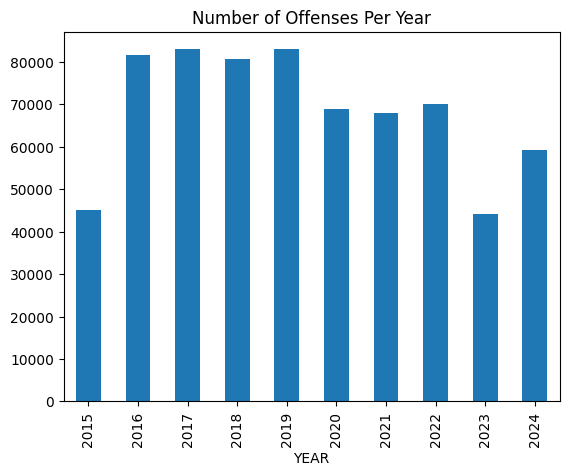

In [31]:
import matplotlib.pyplot as plt

# Offenses per year
new_df.groupby('YEAR')['OFFENSE_DESCRIPTION'].count().plot(kind='bar', title="Number of Offenses Per Year")

In [33]:
new_df.to_csv("cleaned_df.csv")